<a href="https://colab.research.google.com/github/DaraSamii/DataDays2021/blob/main/cleaning_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dara Samii Login

In [ ]:
from google.colab import drive

drive.mount("/content/dirve")

%cd /content/dirve/MyDrive/programming/DataDays2021/

pwd = %pwd

Mounted at /content/dirve
/content/dirve/MyDrive/programming/DataDays2021


# Dara R Samii Login

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

%cd /content/drive/MyDrive/DataDays2021/

pwd = %pwd
pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1NeV9kUSNckaPIHjzLPWZyNOQzMHsaQFt/DataDays2021


'/content/drive/.shortcut-targets-by-id/1NeV9kUSNckaPIHjzLPWZyNOQzMHsaQFt/DataDays2021'

# install packages

In [ ]:
!pip install parsivar
!pip install git+https://github.com/RoboEpics/roboepics-client.git
!pip install "dask[complete]"
!pip install "featuretools[complete]"

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew
from tqdm import tqdm, trange
import json
from datetime import datetime

import sys
sys.path.insert(0,os.path.join(pwd,'helper'))

import utils as ut

import dask.dataframe as dd

import featuretools as ft
import featuretools.variable_types as vr

from dask.diagnostics import ProgressBar

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Helper Module functions


*   `read_json(path, n_lines_to_read=None)`
    >read json file line by line iteratively (generator function).<br>
    use this function to read json files when you have memory limitations.

*  `normalize_texts(X, use_tqdm=False)`
    >normalize list of sentences

* `make_base_product_names(products_path: str, products_normalized_path: str)`
    >assign each base product a name.<br>
    it is extracted from sellers of that product.

* `aggregate_clicks(search_path, click_path, tag, valid_base_ids)`
    >aggregate clicks on each search record and injects it into the search    
    record

* `aggregate_searches(tag)`
    >aggregates searches based on raw query.

* `normalize_test_queries(queries_test_path, queries_test_normalized_path)`
    >normalize test queries


# setting data paths

In [ ]:
data_folder = os.path.join(pwd,"data")

base_product_path = os.path.join(data_folder,"base_products.json")

products_normalized_path = os.path.join(data_folder, "base_products_normalized.json")

queries_test_offline_path = os.path.join(data_folder, "queries_test_offline.json")

queries_test_offline_normalized_path = os.path.join(data_folder, "queries_test_offline_normalized.json")

products_cleaned_path = os.path.join(data_folder, "products_cleaned_path.json")

search_log_train_path = os.path.join(data_folder, "search_log_train.json")

click_log_train_path = os.path.join(data_folder, "click_log_train.json")

# Normalizing test queris with helper function

In [ ]:
utils.normalize_test_queries(queries_test_offline_path, queries_test_offline_normalized_path)

38724it [00:15, 2487.51it/s]


# Modifing train datasets

## cleaning products dataset

In [ ]:
def normalize_product(product):
    record = {}
    pr_name = ""
    for seller in product["sellers"]:
        pr_name += " " + seller["name1"] + " " + seller["name2"]
    words = [w.strip() for w in pr_name.split()]
    words = set([w for w in words if w != ""])
    pr_name = (" ".join(words)).strip()

    record["_id"] = product["_id"]
    record["category_name"] = product["category_name"]
    record["product_name_normalized"] = utils._normalize_text(pr_name)

    record["sellers"] = product["sellers"]
    sellers_list = product["sellers"]
    sellers_count = len(sellers_list)

    all_prices = []
    avaliable_prices = []
    added_dates = []
    count_available = 0
    for i in range(sellers_count):
        all_prices.append(sellers_list[i]["price"])
        added_dates.append(sellers_list[i]["date_added"])

        if sellers_list[i]["availability"] == True:
            count_available += 1
            avaliable_prices.append(sellers_list[i]["price"])

    record["sellers_count"] = sellers_count

    if sellers_count != 0:
        record["availabilty_ratio"] = count_available/sellers_count
        record["mean_all_price"] = float(np.mean(all_prices))
        record["max_all_price"] = float(np.max(all_prices))
        record["min_all_price"] = float(np.min(all_prices))
        record["std_all_price"] = float(np.std(all_prices))
        record["skew_all_price"] = float(skew(all_prices))

        added_dates = list(map(lambda x: datetime.fromisoformat(x),added_dates))
        record["first_added_date"] = min(added_dates).isoformat()
        record["last_added_date"] = max(added_dates).isoformat()


    if count_available != 0:
        record["mean_available_price"] = float(np.mean(avaliable_prices))
        record["max_available_price"] = float(np.max(avaliable_prices))
        record["min_available_price"] = float(np.min(avaliable_prices))
        record["std_available_price"] = float(np.std(avaliable_prices))
        record["skew_available_price"] = float(skew(avaliable_prices))


    return record

In [ ]:
def product_normalizer(products_path: str, products_normalized_path: str):
    """
    assign each base product a name.
    it is extracted from sellers of that product.
    """

    with utils.JSONListWriter(products_normalized_path) as file:
        for product in tqdm(utils.read_json(products_path)):
            normalized_product = normalize_product(product)

            file.write_item(normalized_product)

In [ ]:
product_normalizer(base_product_path,products_cleaned_path)

## reading cleaned product data

In [ ]:
ddd = dd.read_json(products_cleaned_path,blocksize=2**24)

In [ ]:
products_df = ddd.drop('sellers',axis=1)
products_df.head()

,_id,category_name,product_name_normalized,sellers_count,availabilty_ratio,mean_all_price,max_all_price,min_all_price,std_all_price,skew_all_price,first_added_date,last_added_date,mean_available_price,max_available_price,min_available_price,std_available_price,skew_available_price
0,yxwrs,ویدیو پروژکتور اپتما,optoma دیتا خانگی 1920 x 1080 3 d صفحه پروژکتو...,6,0.166667,1.625193e+07,31852600.0,11500000.0,7.104350e+06,1.655126,2017-09-12T07:02:11.544133+00:00,2020-01-25T20:08:23.497684+00:00,3.185260e+07,31852600.0,31852600.0,0.000000,0.000000
1,mbeby,تقویت کننده مژه و ابرو,کننده mascara ژل gel and essence mascara essen...,33,0.696970,6.681758e+04,125000.0,2430.0,2.521815e+04,-0.605363,2019-02-27T20:21:32.020047+00:00,2021-03-10T12:18:51.632557+00:00,7.282826e+04,125000.0,21500.0,20905.381178,-0.133438
2,yovgc,مام و اسپری,tuning v 8 stick ایت وزن دیودرانت استیک تعریق ...,5,0.000000,3.120000e+04,60000.0,0.0,1.907249e+04,-0.185370,2019-04-30T19:05:27.777683+00:00,2020-05-14T15:16:17.862829+00:00,NaN,NaN,NaN,NaN,NaN
3,yokff,مام و اسپری,women رول stick 40 ml 48 h وزن دیودرانت algodo...,16,0.750000,5.606750e+04,99500.0,40000.0,1.464371e+04,1.745850,2019-01-16T13:52:02.755639+00:00,2021-02-03T23:39:02.823359+00:00,5.916500e+04,99500.0,45000.0,15565.639777,1.448900
4,uduyq,گوشی هوآوی,ascend huawei موبایل 550 مدل گوشی 4 g وای y 55...,5,0.000000,7.100000e+04,355000.0,0.0,1.420000e+05,1.500000,2017-04-24T19:33:29.044830+00:00,2018-03-12T10:26:23.683039+00:00,NaN,NaN,NaN,NaN,NaN


## reading search dataset

In [ ]:
search_df = dd.read_json(search_log_train_path,blocksize=2**24)
search_df.head()

,_id,raw_query,page,result,datetime
0,609d7e3a6c2e88f6b241b089,گوشی موبایل,3,"[mmmmm, mmmmy, mmmmu, mmmmk, mmmmb, mmmma, mmm...",2021-05-13 19:30:02.664
1,609d7e4802589dff17211ce4,گوشی,38,"[mmmmn, mmmmi, mmmmo, mmmmx, mmmms, mmmmw, mmm...",2021-05-13 19:30:16.244
2,609d7e4aa0194216c0994b29,گوشی سامسونگ,0,"[mmmmq, mmmmv, mmmml, mmmmp, mmmmj, mmmmh, mmm...",2021-05-13 19:30:18.246
3,609d7e58efd179e80a6fcd99,گوشی,39,"[mmmka, mmmkz, mmmkf, mmmkg, mmmkx]",2021-05-13 19:30:32.254
4,609d7e5b8c23961847786454,گوشی,7,"[mmmks, mmmkw, mmmke, mmmkr, mmmkc, mmmkq, mmm...",2021-05-13 19:30:35.460


## reading click dataset

In [ ]:
click_df = dd.read_json(click_log_train_path,blocksize=2**23)
click_df.head()

,datetime,search_log_id,rank,base_product_id
0,2021-05-13 19:30:47.249,609d7e4802589dff17211ce4,386,mmmmw
1,2021-05-13 19:31:14.383,609d7e58efd179e80a6fcd99,394,mmmkf
2,2021-05-13 19:31:56.974,609d7e3a6c2e88f6b241b089,34,mmmmb
3,2021-05-13 19:32:13.437,609d7eac2bf9491ab8fa0275,444,mmmtq
4,2021-05-13 19:32:14.086,609d7ea747bd1ff6b3eac1ba,4,mmmmq


# Merging clicked and search datasets

In [ ]:
es = ft.EntitySet(id='merged_click_search') 

## adding entities

In [ ]:
es.entity_from_dataframe(entity_id="searches",dataframe=search_df,index="_id",
                         variable_types = {"raw_query":vr.NaturalLanguage,
                                           "page":vr.Ordinal,
                                           "result": vr.Unknown,
                                           "datetime":vr.Datetime,
                                           })

Entityset: merged_click_search
  Entities:
    searches [Rows: Delayed('int-a7737471-2282-4be6-bbfd-5eaf5340afc2'), Columns: 5]
  Relationships:
    No relationships

In [ ]:
es.entity_from_dataframe(entity_id="clicks",dataframe=click_df,index="_id",
                         variable_types = {"search_log_id":vr.Id,
                                           "base_product_id":vr.Id,
                                           "rank":vr.Ordinal,
                                           "datetime":vr.Datetime
                                           })

/usr/local/lib/python3.7/dist-packages/featuretools/entityset/entity.py:463: UserWarning: index _id not found in dataframe, creating new integer column
  "integer column".format(index))


Entityset: merged_click_search
  Entities:
    searches [Rows: Delayed('int-0d0c86a7-7a71-4e67-bfd2-c84e119f2204'), Columns: 5]
    clicks [Rows: Delayed('int-c0349eb5-9747-446b-ade3-96b220a24560'), Columns: 5]
  Relationships:
    No relationships

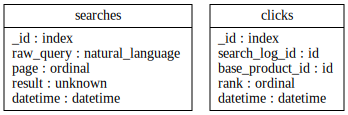

In [ ]:
es.plot()

## adding Relationships

In [ ]:
rel = ft.Relationship(es["searches"]["_id"],es["clicks"]["search_log_id"])
es.add_relationship(rel)

Entityset: merged_click_search
  Entities:
    searches [Rows: Delayed('int-07eebe0d-25bc-45aa-a2ee-29552a2ff426'), Columns: 5]
    clicks [Rows: Delayed('int-5fde64d6-90c2-411d-ab7b-75f5c0e50293'), Columns: 5]
  Relationships:
    clicks.search_log_id -> searches._id

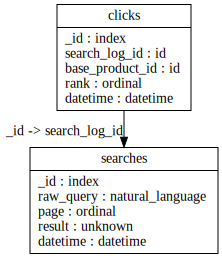

In [ ]:
es.plot()

## deep feature synthesis

In [ ]:
feature_matrix, feature_defs = ft.dfs(entityset=es,
                                      target_entity="clicks",
                                      agg_primitives = [],
                                      trans_primitives= [], 
                                      return_variable_types =[vr.Numeric,vr.Categorical,vr.Boolean,
                                                              vr.Unknown,vr.NaturalLanguage,
                                                              vr.Datetime,vr.Ordinal],
                                      max_depth = 5,verbose=2,
                                      )

Built 8 features
Elapsed: 00:00 | Progress: 100%|██████████


In [ ]:
feature_defs

[<Feature: search_log_id>,
 <Feature: base_product_id>,
 <Feature: rank>,
 <Feature: datetime>,
 <Feature: searches.raw_query>,
 <Feature: searches.page>,
 <Feature: searches.result>,
 <Feature: searches.datetime>]

In [ ]:
feature_matrix

,search_log_id,base_product_id,rank,datetime,searches.raw_query,searches.page,searches.result,searches.datetime,_id
npartitions=97,,,,,,,,,
,object,object,int64,datetime64[ns],object,int64,object,datetime64[ns],int64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


In [ ]:
with ProgressBar():
    click_search_merged = feature_matrix.persist(optimize_graph=True)

[########################################] | 100% Completed |  6min  5.9s


In [ ]:
click_search_merged.head()

,search_log_id,base_product_id,rank,datetime,searches.raw_query,searches.page,searches.result,searches.datetime,_id
0,60763a12a7a6f06f7c6ef4f7,mnvzc,172,2021-04-14 00:41:05.035,پاور بانک سیلیکون پاور,17,"[mywzb, mfveo, mnvzc, mozvc, bbfhh, mmmsw, mxx...",2021-04-14 00:40:50.620,6312026
1,6076aceb01d68ef900f55c18,mflrp,5,2021-04-14 08:51:33.059,یخچال فریزر الجی,0,"[muvux, mmjii, mmjfs, mmhml, muvkq, mflrp, myk...",2021-04-14 08:50:51.477,6312123
2,6076ef43629a5bb74738c42e,uimha,10,2021-04-14 16:48:08.525,تاپ شلوارک زنانه,1,"[uimha, mstkm, mxsqf, uprel, msvfv, ujelk, uje...",2021-04-14 13:33:55.154,6312368
3,60772e3bc609270e36522d07,msztn,43,2021-04-14 18:02:51.489,لباس دخترونه پرسپولیسی,4,"[moadq, bojii, bojio, msztn, upqnk, koyhq, kfh...",2021-04-14 18:02:35.654,6312422
4,6075fbf7c977e36561aac9ae,kemjh,138,2021-04-13 20:16:05.349,ساعت مچی عقربه ای مردانه,13,"[yucxn, yuprn, mimrt, upzlm, yhywp, mmhry, mya...",2021-04-13 20:15:51.072,6312486


## saving files

In [ ]:
paths = []
for i in range(5):
    paths.append(os.path.join(data_folder, "search_clicks_merged{}.csv".format(i)))
paths

['/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged0.csv',
 '/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged1.csv',
 '/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged2.csv',
 '/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged3.csv',
 '/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged4.csv']

In [ ]:
with ProgressBar():
    click_search_merged.to_csv(paths)

[########################################] | 100% Completed |  3.9s


## breaking result list and some cleaning

In [ ]:
for path in paths:
    print("start")
    df = pd.read_csv(path)
    df = df.assign(product_showed=df["searches.result"].str.split(",")).explode('product_showed')
    df["product_showed"] = df["product_showed"].apply(lambda x:x.replace("[","").replace("]","").replace("\'","").strip())
    df["is_clicked"] = df.apply(lambda x: True if x["product_showed"] == x["base_product_id"] else False,axis=1)

    df.drop(["searches.result","datetime","base_product_id"],axis=1,inplace=True)
    df.to_csv(path,)
    print(path)


start
/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged0.csv
start
/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged1.csv
start
/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged2.csv
start
/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged3.csv
start
/content/dirve/MyDrive/programming/DataDays2021/data/search_clicks_merged4.csv


# Merging product dataset

In [ ]:
merged_clicks = dd.read_csv(paths).drop(["Unnamed: 0","Unnamed: 0.1","search_log_id"],axis=1)
merged_clicks = merged_clicks.rename(columns={"searches.raw_query": "raw_query", "searches.page": "page","searches.datetime":"datetime"})

In [ ]:
merged_clicks.head(10)

,rank,raw_query,page,datetime,_id,product_showed,is_clicked
0,172,پاور بانک سیلیکون پاور,17,2021-04-14 00:40:50.620,6312026,mywzb,False
1,172,پاور بانک سیلیکون پاور,17,2021-04-14 00:40:50.620,6312026,mfveo,False
2,172,پاور بانک سیلیکون پاور,17,2021-04-14 00:40:50.620,6312026,mnvzc,True
3,172,پاور بانک سیلیکون پاور,17,2021-04-14 00:40:50.620,6312026,mozvc,False
4,172,پاور بانک سیلیکون پاور,17,2021-04-14 00:40:50.620,6312026,bbfhh,False
5,172,پاور بانک سیلیکون پاور,17,2021-04-14 00:40:50.620,6312026,mmmsw,False
6,172,پاور بانک سیلیکون پاور,17,2021-04-14 00:40:50.620,6312026,mxxtl,False
7,172,پاور بانک سیلیکون پاور,17,2021-04-14 00:40:50.620,6312026,myzak,False
8,5,یخچال فریزر الجی,0,2021-04-14 08:50:51.477,6312123,muvux,False
9,5,یخچال فریزر الجی,0,2021-04-14 08:50:51.477,6312123,mmjii,False


## adding entities

In [ ]:
es = ft.EntitySet(id="complete")

In [ ]:
es.entity_from_dataframe(entity_id="products",dataframe=products_df,index="_id",
                         variable_types = {
                             "category_name":vr.Categorical,
                             "product_name_normalized":vr.NaturalLanguage,
                             "first_added_date":vr.Datetime,
                             "last_added_date":vr.Datetime,
                             "sellers_count":vr.Numeric,
                             "availabilty_ratio":vr.Numeric,
                             "mean_all_price":vr.Numeric,
                             "max_all_price":vr.Numeric,
                             "min_all_price":vr.Numeric,
                             "std_all_price":vr.Numeric,
                             "skew_all_price":vr.Numeric,
                             "mean_available_price":vr.Numeric,
                             "max_available_price":vr.Numeric,
                             "min_available_price":vr.Numeric,
                             "std_available_price":vr.Numeric,
                             "skew_available_price":vr.Numeric,
                         })

Entityset: complete
  Entities:
    products [Rows: Delayed('int-d550bd00-eb3d-4801-ba9f-881c44978614'), Columns: 17]
  Relationships:
    No relationships

In [ ]:
es.entity_from_dataframe(entity_id="clicked_merged",dataframe=merged_clicks,index="_id",
                         variable_types = {"rank":vr.Ordinal,
                                           "raw_query": vr.NaturalLanguage,
                                           "page":vr.Ordinal,
                                           "datetime":vr.Datetime,
                                           "product_showed":vr.Id,
                                           "is_clicked":vr.Boolean,
                                           "_id":vr.Index
                         })

Entityset: complete
  Entities:
    products [Rows: Delayed('int-ef15d8b2-153c-4a22-a296-6604b93ec8c0'), Columns: 17]
    clicked_merged [Rows: Delayed('int-50356818-08d3-4b48-8628-acbfb85c5be0'), Columns: 7]
  Relationships:
    No relationships

## adding realationships

In [ ]:
 rel = ft.Relationship(es["products"]["_id"],es["clicked_merged"]["product_showed"])
es.add_relationship(rel)

Entityset: complete
  Entities:
    products [Rows: Delayed('int-19c634bd-49f0-4c75-a830-c0624d4d653d'), Columns: 17]
    clicked_merged [Rows: Delayed('int-58bb3933-f4ca-48b0-97f4-338a04655be9'), Columns: 7]
  Relationships:
    clicked_merged.product_showed -> products._id

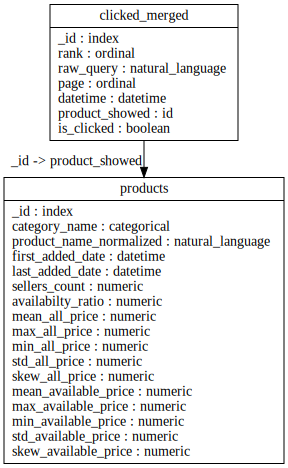

In [ ]:
es.plot()

## deep feature synthesis clicks

In [ ]:
aggregation_primitives = ["Std","Max","Min","Count","percent_true","mean","Sum"]
transform_primitives = ["Year","Month","Weekday","Day","hour","minute","is_weekend","Num_Words"]

In [ ]:
feature_matrix , defs = ft.dfs(entityset=es,target_entity="clicked_merged",
                               agg_primitives = aggregation_primitives, trans_primitives = transform_primitives,
                               return_variable_types = [vr.NaturalLanguage,vr.Numeric,vr.Ordinal,vr.Categorical,vr.Boolean],
                               verbose = True,max_depth=2)

Built 44 features


/usr/local/lib/python3.7/dist-packages/featuretools/synthesis/dfs.py:307: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['Day', 'Month', 'Num_Words', 'Weekday', 'Year']
  agg_primitives: ['Count', 'Max', 'Min', 'Std', 'Sum', 'mean']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Elapsed: 00:00 | Progress: 100%|██████████


In [ ]:
defs

[<Feature: rank>,
 <Feature: raw_query>,
 <Feature: page>,
 <Feature: product_showed>,
 <Feature: is_clicked>,
 <Feature: DAY(datetime)>,
 <Feature: HOUR(datetime)>,
 <Feature: IS_WEEKEND(datetime)>,
 <Feature: MINUTE(datetime)>,
 <Feature: MONTH(datetime)>,
 <Feature: NUM_WORDS(raw_query)>,
 <Feature: WEEKDAY(datetime)>,
 <Feature: YEAR(datetime)>,
 <Feature: products.category_name>,
 <Feature: products.product_name_normalized>,
 <Feature: products.sellers_count>,
 <Feature: products.availabilty_ratio>,
 <Feature: products.mean_all_price>,
 <Feature: products.max_all_price>,
 <Feature: products.min_all_price>,
 <Feature: products.std_all_price>,
 <Feature: products.skew_all_price>,
 <Feature: products.mean_available_price>,
 <Feature: products.max_available_price>,
 <Feature: products.min_available_price>,
 <Feature: products.std_available_price>,
 <Feature: products.skew_available_price>,
 <Feature: products.COUNT(clicked_merged)>,
 <Feature: products.PERCENT_TRUE(clicked_merged.is_c

In [ ]:
feature_matrix

,rank,raw_query,page,product_showed,is_clicked,DAY(datetime),HOUR(datetime),IS_WEEKEND(datetime),MINUTE(datetime),MONTH(datetime),NUM_WORDS(raw_query),WEEKDAY(datetime),YEAR(datetime),products.category_name,products.product_name_normalized,products.sellers_count,products.availabilty_ratio,products.mean_all_price,products.max_all_price,products.min_all_price,products.std_all_price,products.skew_all_price,products.mean_available_price,products.max_available_price,products.min_available_price,products.std_available_price,products.skew_available_price,products.COUNT(clicked_merged),products.PERCENT_TRUE(clicked_merged.is_clicked),products.DAY(first_added_date),products.DAY(last_added_date),products.HOUR(first_added_date),products.HOUR(last_added_date),products.IS_WEEKEND(first_added_date),products.IS_WEEKEND(last_added_date),products.MINUTE(first_added_date),products.MINUTE(last_added_date),products.MONTH(first_added_date),products.MONTH(last_added_date),products.NUM_WORDS(product_name_normalized),products.WEEKDAY(first_added_date),products.WEEKDAY(last_added_date),products.YEAR(first_added_date),products.YEAR(last_added_date),_id
npartitions=128,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,int64,object,bool,int64,int64,bool,int64,int64,int64,int64,int64,object,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
with ProgressBar():
    computed_data = feature_matrix.compute(optimize_graph=True)

[########################################] | 100% Completed |  7min 50.1s


In [ ]:
computed_data.head()


,rank,raw_query,page,product_showed,is_clicked,DAY(datetime),HOUR(datetime),IS_WEEKEND(datetime),MINUTE(datetime),MONTH(datetime),NUM_WORDS(raw_query),WEEKDAY(datetime),YEAR(datetime),products.category_name,products.product_name_normalized,products.sellers_count,products.availabilty_ratio,products.mean_all_price,products.max_all_price,products.min_all_price,products.std_all_price,products.skew_all_price,products.mean_available_price,products.max_available_price,products.min_available_price,products.std_available_price,products.skew_available_price,products.COUNT(clicked_merged),products.PERCENT_TRUE(clicked_merged.is_clicked),products.DAY(first_added_date),products.DAY(last_added_date),products.HOUR(first_added_date),products.HOUR(last_added_date),products.IS_WEEKEND(first_added_date),products.IS_WEEKEND(last_added_date),products.MINUTE(first_added_date),products.MINUTE(last_added_date),products.MONTH(first_added_date),products.MONTH(last_added_date),products.NUM_WORDS(product_name_normalized),products.WEEKDAY(first_added_date),products.WEEKDAY(last_added_date),products.YEAR(first_added_date),products.YEAR(last_added_date),_id
0,0,ماشین پژو پارس,0,mnlmg,False,14,5,False,33,4,3,2,2021,سایر لوازم تزئینی خودرو,پارس جلو پهن پژو اکورد طرح نیون چراغ اسپرت بلوری,1,1.0,810000.0,810000.0,810000.0,0.0,0.0,810000.0,810000.0,810000.0,0.0,0.0,31,0.032258,20,20,3,3,False,False,57,57,11,11,10,2,2,2019,2019,6312613
1,49,دامن شلواری,2,ydpvn,False,14,14,False,5,4,2,2,2021,شلوار و دامن زنانه,شلواری دامن راحت,1,0.0,599000.0,599000.0,599000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1,0.000000,5,5,19,19,False,False,38,38,1,1,3,1,1,2021,2021,6313848
2,42,کفش چرم زنانه,1,micot,False,14,5,False,48,4,3,2,2021,کفش و صندل زنانه,کفش چرم طبی کد 428 معراج زنانه,1,1.0,470000.0,470000.0,470000.0,0.0,0.0,470000.0,470000.0,470000.0,0.0,0.0,4,0.000000,27,27,21,21,True,True,3,3,2,2,7,5,5,2021,2021,6314214
3,22,وافل ساز,2,mjtxs,False,13,21,False,23,4,2,1,2021,ساندویچ ساز و وافل ساز,صنعتی تخم ساز مرغی بست pfy 2 وافل,1,1.0,3500000.0,3500000.0,3500000.0,0.0,0.0,3500000.0,3500000.0,3500000.0,0.0,0.0,12,0.083333,2,2,10,10,True,True,26,26,1,1,8,5,5,2021,2021,6246255
4,22,وافل ساز,2,mjtxs,False,13,21,False,23,4,2,1,2021,ساندویچ ساز و وافل ساز,صنعتی تخم ساز مرغی بست pfy 2 وافل,1,1.0,3500000.0,3500000.0,3500000.0,0.0,0.0,3500000.0,3500000.0,3500000.0,0.0,0.0,12,0.083333,2,2,10,10,True,True,26,26,1,1,8,5,5,2021,2021,6246256


### saving clicks

In [ ]:
final_clicked = os.path.join(data_folder,"final","final_clicked.csv")
final_clicked

'/content/dirve/MyDrive/programming/DataDays2021/data/final/final_clicked.csv'

In [ ]:
with ProgressBar():
  computed_data.to_csv(final_clicked)

## deep feature sysnthesis products

In [ ]:
aggregation_primitives = ["Count","percent_true"]
transform_primitives = ["Year","Month","Weekday","Day","hour","minute","is_weekend","Num_Words"]

In [ ]:
feature_matrix , defs = ft.dfs(entityset=es,target_entity="products",
                               agg_primitives = aggregation_primitives, trans_primitives = transform_primitives,
                               return_variable_types = [vr.NaturalLanguage,vr.Numeric,vr.Ordinal,vr.Categorical,vr.Boolean],
                               verbose = True,max_depth=2)

In [ ]:
defs

[<Feature: category_name>,
 <Feature: product_name_normalized>,
 <Feature: sellers_count>,
 <Feature: availabilty_ratio>,
 <Feature: mean_all_price>,
 <Feature: max_all_price>,
 <Feature: min_all_price>,
 <Feature: std_all_price>,
 <Feature: skew_all_price>,
 <Feature: mean_available_price>,
 <Feature: max_available_price>,
 <Feature: min_available_price>,
 <Feature: std_available_price>,
 <Feature: skew_available_price>,
 <Feature: COUNT(clicked_merged)>,
 <Feature: PERCENT_TRUE(clicked_merged.is_clicked)>,
 <Feature: DAY(first_added_date)>,
 <Feature: DAY(last_added_date)>,
 <Feature: HOUR(first_added_date)>,
 <Feature: HOUR(last_added_date)>,
 <Feature: IS_WEEKEND(first_added_date)>,
 <Feature: IS_WEEKEND(last_added_date)>,
 <Feature: MINUTE(first_added_date)>,
 <Feature: MINUTE(last_added_date)>,
 <Feature: MONTH(first_added_date)>,
 <Feature: MONTH(last_added_date)>,
 <Feature: NUM_WORDS(product_name_normalized)>,
 <Feature: WEEKDAY(first_added_date)>,
 <Feature: WEEKDAY(last_adde

In [ ]:
with ProgressBar():
  computed = feature_matrix.compute(optimize_graph = True)

[########################################] | 100% Completed | 13min 45.6s


In [ ]:
computed.head()

,category_name,product_name_normalized,sellers_count,availabilty_ratio,mean_all_price,max_all_price,min_all_price,std_all_price,skew_all_price,mean_available_price,max_available_price,min_available_price,std_available_price,skew_available_price,COUNT(clicked_merged),PERCENT_TRUE(clicked_merged.is_clicked),DAY(first_added_date),DAY(last_added_date),HOUR(first_added_date),HOUR(last_added_date),IS_WEEKEND(first_added_date),IS_WEEKEND(last_added_date),MINUTE(first_added_date),MINUTE(last_added_date),MONTH(first_added_date),MONTH(last_added_date),NUM_WORDS(product_name_normalized),WEEKDAY(first_added_date),WEEKDAY(last_added_date),YEAR(first_added_date),YEAR(last_added_date),PERCENT_TRUE(clicked_merged.IS_WEEKEND(datetime)),_id
0,ویدیو پروژکتور اپتما,optoma دیتا خانگی 1920 x 1080 3 d صفحه پروژکتو...,6,0.166667,1.625193e+07,31852600.0,11500000.0,7.104350e+06,1.655126,3.185260e+07,31852600.0,31852600.0,0.000000,0.000000,0.0,0.000000,12.0,25.0,7.0,20.0,False,True,2.0,8.0,9.0,1.0,38,1.0,5.0,2017.0,2020.0,0.000000,yxwrs
1,تقویت کننده مژه و ابرو,کننده mascara ژل gel and essence mascara essen...,33,0.696970,6.681758e+04,125000.0,2430.0,2.521815e+04,-0.605363,7.282826e+04,125000.0,21500.0,20905.381178,-0.133438,12.0,0.166667,27.0,10.0,20.0,12.0,False,False,21.0,18.0,2.0,3.0,40,2.0,2.0,2019.0,2021.0,0.333333,mbeby
2,مام و اسپری,tuning v 8 stick ایت وزن دیودرانت استیک تعریق ...,5,0.000000,3.120000e+04,60000.0,0.0,1.907249e+04,-0.185370,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,30.0,14.0,19.0,15.0,False,False,5.0,16.0,4.0,5.0,22,1.0,3.0,2019.0,2020.0,0.000000,yovgc
3,مام و اسپری,women رول stick 40 ml 48 h وزن دیودرانت algodo...,16,0.750000,5.606750e+04,99500.0,40000.0,1.464371e+04,1.745850,5.916500e+04,99500.0,45000.0,15565.639777,1.448900,0.0,0.000000,16.0,3.0,13.0,23.0,False,False,52.0,39.0,1.0,2.0,46,2.0,2.0,2019.0,2021.0,0.000000,yokff
4,گوشی هوآوی,ascend huawei موبایل 550 مدل گوشی 4 g وای y 55...,5,0.000000,7.100000e+04,355000.0,0.0,1.420000e+05,1.500000,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,24.0,12.0,19.0,10.0,False,False,33.0,26.0,4.0,3.0,16,0.0,0.0,2017.0,2018.0,0.000000,uduyq


In [ ]:
final_products = os.path.join(data_folder,"final","final_products.csv")
final_products

'/content/dirve/MyDrive/programming/DataDays2021/data/final/final_products.csv'

In [ ]:
with ProgressBar():
  computed.to_csv(final_products)

# reading test queries

In [ ]:
import pandas as pd
from tqdm import tqdm
import json

In [ ]:
queries_test_offline_normalized_path

'/content/dirve/MyDrive/programming/DataDays2021/data/queries_test_offline_normalized.json'

In [ ]:
def read_json(path, n_lines_to_read=None):
    """
    read json file line by line iteratively (generator function).
    use this function to read json files when you have memory limitations.
    """

    with open(path) as f:
        for i, line in enumerate(tqdm(f)):
            if n_lines_to_read == i:
                break
            yield json.loads(line)

In [ ]:
g = read_json(queries_test_offline_normalized_path,10)

In [ ]:
for i,p in enumerate(g):
  print(p)


1it [00:29, 29.28s/it]

قهوه ساز delongi
بند فلزی mi band 5
قالی زمردمشهد
پوکو x 3 pro
xiaomi redmi note 9 s
40 d
لباس انا
سنگ چشم ببر
گلگیر جلو پژو 405 شرکتی
